# OpenVINO example with Squeezenet Model

This notebook illustrates how you can serve [OpenVINO](https://software.intel.com/en-us/openvino-toolkit) optimized models for Imagenet with Seldon Core.

![car](car.png)

   
To run all of the notebook successfully you will need to start it with
```
jupyter notebook --NotebookApp.iopub_data_rate_limit=100000000
```

## Setup Seldon Core

Use the setup notebook to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) with [Ambassador Ingress](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Ambassador) and [Install Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Install-Seldon-Core). Instructions [also online](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html).

In [1]:
!kubectl create namespace seldon

Error from server (AlreadyExists): namespaces "seldon" already exists


## Deploy Seldon Intel OpenVINO Graph

In [7]:
!helm install -n seldon openvino-squeezenet ../../../helm-charts/seldon-openvino \
    --set openvino.model.src=gs://seldon-models/openvino/squeezenet \
    --set openvino.model.path=/opt/ml/squeezenet \
    --set openvino.model.name=squeezenet1.1 \
    --set openvino.model.input=data \
    --set openvino.model.output=prob 

NAME: openvino-squeezenet
LAST DEPLOYED: Tue Nov 18 16:59:40 2025
NAMESPACE: seldon
STATUS: deployed
REVISION: 1
TEST SUITE: None


In [8]:
!helm template openvino-squeezenet ../../../helm-charts/seldon-openvino \
    --set openvino.model.src=gs://seldon-models/openvino/squeezenet \
    --set openvino.model.path=/opt/ml/squeezenet \
    --set openvino.model.name=squeezenet1.1 \
    --set openvino.model.input=data \
    --set openvino.model.output=prob | pygmentize -l json

---
# Source: seldon-openvino/templates/openvino_deployment.json
{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {"app":"seldon"},
        "name": "openvino-model",
	"namespace": "seldon"	
    },
    "spec": {
        "name": "openvino",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
			"initContainers" : [
			    {
				"image": "kfserving/storage-initializer:v0.6.1",
				"name": "storage-initializer",
				"args": [ "gs://seldon-models/openvino/squeezenet", "/opt/ml" ],
				"volumeMounts": [
				    {
					"name": "modelstore",
					"mountPath": "/opt/ml"
				    }
				]
			    }
			],
                        "containers": [
                            {
                                "image": "seldonio/tfserving-proxy:0.2",
                                "name": "tfserving-proxy",
				"volumeMounts": [
				    {
					"name": "modelstore",
					"moun

In [9]:
!kubectl wait sdep/openvino-model \
  --for=condition=ready \
  --timeout=120s \
  -n seldon

seldondeployment.machinelearning.seldon.io/openvino-model condition met


## Test


2025-11-18 17:01:00.909110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763485260.926495 3759297 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763485260.931903 3759297 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-18 17:01:00.950232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(1, 3, 227, 227)


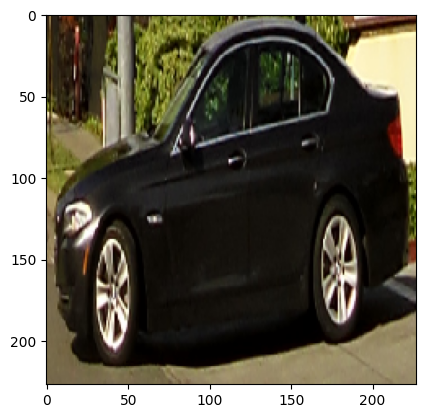

In [10]:
%matplotlib inline
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.preprocessing import image

from seldon_core.seldon_client import SeldonClient


def getImage(path):
    img = image.load_img(path, target_size=(227, 227))
    x = image.img_to_array(img)
    plt.imshow(x / 255.0)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


X = getImage("car.png")
X = X.transpose((0, 3, 1, 2))
print(X.shape)

sc = SeldonClient(deployment_name="openvino-model", namespace="seldon")

In [11]:

from tenacity import retry, stop_after_delay, wait_exponential

@retry(stop=stop_after_delay(300), wait=wait_exponential(multiplier=1, min=0.5, max=5))
def predict():
    response = sc.predict(
        gateway="ambassador", transport="grpc", data=X, client_return_type="proto"
    )

    result = response.response.data.tensor.values

    result = np.array(result)
    result = result.reshape(1, 1000)

    with open("imagenet_classes.json") as f:
        cnames = eval(f.read())

        for i in range(result.shape[0]):
            single_result = result[[i], ...]
            ma = np.argmax(single_result)
            print("\t", i, cnames[ma])
            assert cnames[ma] == "sports car, sport car"

predict()

	 0 sports car, sport car


In [13]:
!helm delete -n seldon openvino-squeezenet

Error: uninstall: Release not loaded: openvino-squeezenet: release: not found
